# Tutorials on computing the RG flow and finite bond-dimension effects


### In this notebook, I show the demo codes of the computations with Loop-TNR in [my paper](https://arxiv.org/abs/2302.06632). Please find detailed descriptions there.


### The main focus is 
- Computation of the finite bond-dimension effect in Loop-TNR
- Finite-entanglement scaling of the energy gap/correlation length at criticality
- Visualization of the RG flow in the vicinity of the Ising fixed point

There are several implementations of initial tensors for other models in "Initialization.py". You may examine those models by simply changing the initial "tA" and "tB" tensors.

In [1]:
import numpy as np
from tqdm import tqdm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from Initialization import initialize_Ising
import loop_opt as tnr
import cft

Ising_Tc = 2./np.log(1.+np.sqrt(2))

In [2]:
def collect_Ising(T, d_cut, size):
    # The scaling dimension is computed from 2x2 transfer matrix.
    keep_num_scaling = d_cut ** 2
    error_limit = 1.0E-14
    maxloop = 80
    area = 4.

    cft_result = np.zeros((size, keep_num_scaling))
    norm_list = []
    # Setting the initial tensor. CHANGE HERE IF YOU LIKE TO INVESTIGATE OTHER MODELS. 
    tA = initialize_Ising(T)
    tB = np.copy(tA)

    tA, tB, norm = tnr.normalize_tensor(tA, tB)
    norm_list.append(norm)
    ln_z = np.log(norm)/area

    for i in tqdm(range(size)):
        # one renormalization step(filtering/svd/optimizing/truncation/normalization) can be done with tnr.TNR_step
        tA, tB, norm = tnr.TNR_step(tA,tB,d_cut,error_limit,maxloop)
        area *= 2
        ln_z += np.log(norm) / area
        norm_list.append(norm)
        data = cft.cal_sdimension(tA, tB, norm)
        cft_result[i, 0:min(keep_num_scaling, np.shape(data)[0])] = data[0:min(keep_num_scaling, np.shape(data)[0])]
    np.save("tnr_data/Critical_{}.npy".format(d_cut), cft_result)
    np.save("tnr_data/norm_{}.npy".format(d_cut), norm_list)

In [3]:
#This may take some time if you calculating on your laptop! The npy files are already in the "tnr_data" directory.
# for D in [4,8,12,16,20,24]:
#     collect_Ising(Ising_Tc, D, 30)

## load data from "tnr_data" directory

In [4]:
data=[]
norm_list=[]
D_list=np.array([4,8,12,16,20])
for D in D_list:
    data.append(np.real(np.load("tnr_data/Critical_{}.npy".format(D),allow_pickle=True)))
    norm_list.append(np.real(np.load("tnr_data/norm_{}.npy".format(D),allow_pickle=True))) 
cstart=2

## From "norm_list", we can compute the partition function at finite system sizes.
See /TRG_tutorial for details if you're not familiar with this topic

In [5]:
lnz=np.zeros((len(D_list), len(norm_list[0])))
for i in range(len(D_list)):
    #T
    temp=0
    area=4
    #N
    for j in range(len(norm_list[0])):
        temp+=np.log(np.real(norm_list[i][j]))/area
        lnz[i,j]=temp
        area*=2
lnZ=np.zeros((len(D_list),len(norm_list[0])))
for i in range(len(norm_list[0])):
    lnZ[:,i]=lnz[:,i]*2**(i+2)

The leading eigenvalue is stored in data[i][j][0] with factor 6/π so that it represents the central charge for critical system. 

To recover the original leading eigenvalue, we multiply it with the normalization factor.

In [6]:
lnlambda0=np.zeros((len(D_list),len(data[0])))
for i in range(len(D_list)):
    for j in range(len(data[0])):
        # ln(c) = ln(Λ_0)*6/ pi　（see cft.py)
        lnlambda0[i,j]=np.pi*data[i][j][0]/6+np.log(np.real(norm_list[i][j+1]))
lE0_list=np.zeros((len(D_list),len(data[0])))
for i in range(len(D_list)):
    for j in range(len(data[0])):
        lE0_list[i,j]=-(lnlambda0[i,j]+lnZ[i,j+1])

## Scaling of the ground state energy
We read out the ground state energy of the corresponding 1d quantum systems by $\ln\lambda_0 = -LE_0(L)$. 

In CFT, the ground state scale as 
### $$E_0(L) = \epsilon_0 L - \frac{2\pi}{L}\frac{c}{6},$$
where we set the characteristic velocity $v=1$ because our system is invariant under the exchange of $x$ and $y$ axis.

In [7]:
def parabola_fit(x,a,b):
    return a*x**2+b
l_list=2**(np.linspace(1.5,1+0.5*len(data[0]),len(data[0])))
fd,cov=curve_fit(parabola_fit,l_list[1:8],lE0_list[-1,1:8])

(0.0, 70000.0)

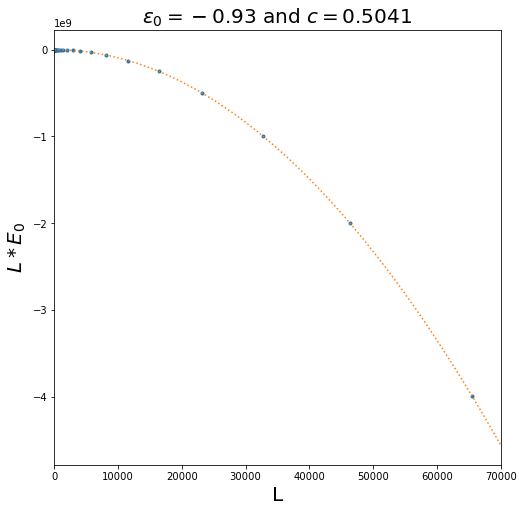

In [8]:
plt.figure(figsize=(8,8))
plt.plot(l_list,lE0_list[-1],".")
plt.plot(np.linspace(0,7e4,1000),parabola_fit(np.linspace(0,7e4,1000),fd[0],1),":",label="Fit")
plt.title(r"$\epsilon_0={0}$ and $c={1}$".format(np.round(fd[0],3),np.round(-fd[1]*6/np.pi,5)),fontsize=20)
plt.ylabel("$L*E_0$",fontsize=20)
plt.xlabel("L",fontsize=20)
plt.xlim(0,7e4)

## Finite bond-dimension effect

### Let us look at the finite-$D$ effect
 We investigate it by plotting 
### $$\delta x_\sigma = x_\sigma(L,D) - 1/8$$

In the $D\rightarrow\infty$ limit, $\delta x_\sigma$ is proportional to $1/L^2$ because the leading irrelevant operator is $T^2$ and $\bar{T}^2$. These operators have conformal spins 4, so it flip the sign every time the lattice is rotated by 45 degrees. 

**The finite bond-dimension effect, on the other hand, results in an increasing contribution to the value of $\delta x_\sigma$.**

See [my paper](https://arxiv.org/abs/2302.06632) for details. 

In [9]:
gap_list=np.zeros((len(D_list),len(data[0])))
for i in range(len(D_list)):
    gap_list[i] = data[i][:,1]
delta_sigma = gap_list - 1/8

Text(0, 0.5, '$\\delta x_\\sigma$')

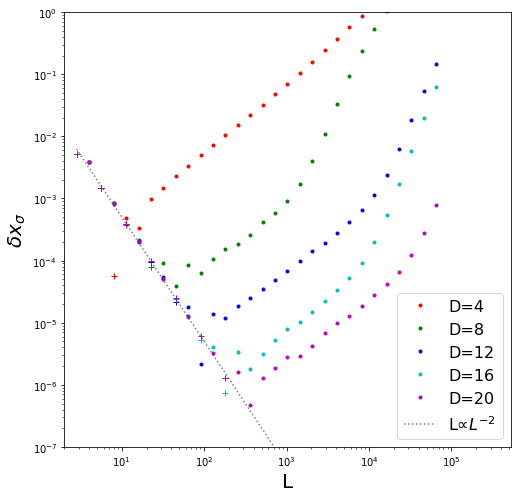

In [10]:
plt.figure(figsize=(8,8))
color_list= ["r", "g", "b", "c", "m"]
for i in range(5):
    plt.plot(l_list,(gap_list[i]-0.125),".",color=color_list[i],label="D={}".format(D_list[i]))
    plt.plot(l_list,-(gap_list[i]-0.125),"+",color=color_list[i])
plt.plot(l_list,0.5e-1* l_list**(-2),":",color="black",alpha = 0.5,label="L∝$L^{-2}$")
plt.xscale("log")
plt.yscale("log")
plt.xlim(2,l_list[-1]*4*2)
plt.ylim(1e-7,1)
plt.legend(loc="lower right",fontsize=16)
plt.xlabel("L",fontsize=20)
plt.ylabel("$\delta x_\sigma$",fontsize=20)

$\delta x_\sigma(L)$ initially follows the finite-size scaling of $L\propto1/L^2$ as denoted with a dotted line. However, **the systems represented by finite bond-dimensions have finite correlation length**. This results in the increase of $\delta x_\sigma(L)$ for larger system sizes. 

Although the behavior of $\delta x_\sigma(L)$ might look different, they collapse with the characteristic lengthscale $\xi(L)$.
$$\xi(D) \sim D^\kappa$$
$$\kappa = \frac{6}{c(1+\sqrt{\frac{12}{c}})}$$

This is often called **Finite entanglement scaling** in MPS contexts.

In [11]:
kappa=6/(0.5*(1+np.sqrt(24)))

Text(0, 0.5, '$L^2\\delta x$')

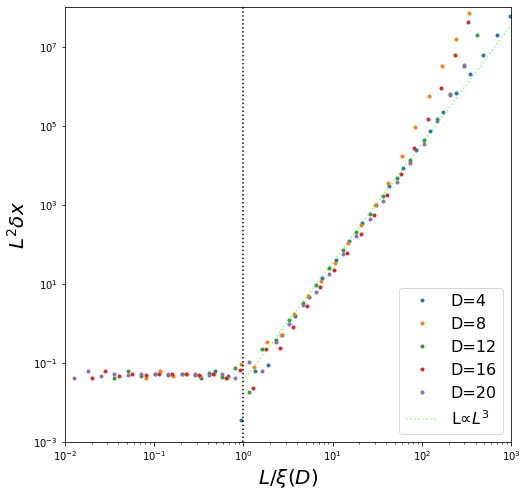

In [12]:
plt.figure(figsize=(8,8))
for i in range(5):
    plt.plot(l_list/(0.5*D_list[i]**kappa),abs(gap_list[i]-0.125)*l_list**2,".",label="D={}".format(D_list[i]))
plt.plot(np.linspace(1,1000,1000),0.035*np.linspace(1,1000,1000)**3,":",color="lime",alpha=0.5,label="L∝$L^3$")
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-2,1e3)
plt.ylim(1e-3,1e8)
plt.axvline(1.,linestyle=":",color="black")
plt.legend(loc="lower right",fontsize=16)
plt.xlabel(r'$L/\xi(D)$',fontsize=20)
plt.ylabel("$L^2\delta x$",fontsize=20)

Text(0, 0.5, '$\\delta x_\\sigma$')

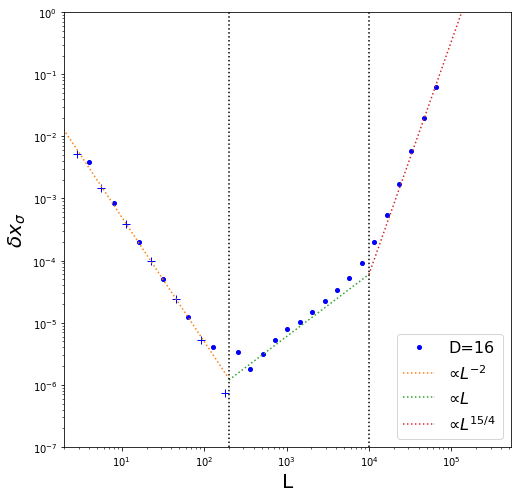

In [13]:
plt.figure(figsize=(8,8))
i=3
plt.plot(l_list,(gap_list[i]-0.125),".",markersize=8,color="blue",label="D={}".format(D_list[i]))
plt.plot(l_list,-(gap_list[i]-0.125),"+",color="blue",markersize=8)
plt.plot(np.linspace(1,200,100),5e-2*np.linspace(1,200,100)**(-2),":",color="C1",label="$∝L^{-2}$")
plt.plot(np.linspace(200,1e4,100),6e-9*np.linspace(200,1e4,100),":",color="C2",label="$∝L$")
plt.plot(np.linspace(1e4,2e5,100),6e-20*np.linspace(1e4,2e5,100)**3.75,":",color="C3",label="$∝L^{15/4}$")
plt.axvline(200.,linestyle=":",color="black")
plt.axvline(1e4,linestyle=":",color="black")
plt.xscale("log")
plt.yscale("log")
plt.xlim(2,l_list[-1]*4*2)
plt.ylim(1e-7,1)
plt.legend(loc="lower right",fontsize=16)
plt.xlabel("L",fontsize=20)
plt.ylabel("$\delta x_\sigma$",fontsize=20)

### When you look at the individual data, you see that the finite bond-dimension effects emerge as relevant perturbations of the Ising criticality.






## Visulalizing the renormalization group flow

Let us compute the off-critical case by computing the rescaled energy level $x_\sigma(L)$ that is slightly away from the criticality.

In [14]:
def collect_Ising_off(T, d_cut, size):
    keep_num_scaling = d_cut ** 2
    error_limit = 1.0E-14
    maxloop = 80
    area = 4.

    cft_result = np.zeros((size, keep_num_scaling))
    norm_list = []

    tA = initialize_Ising(T)
    tB = np.copy(tA)

    tA, tB, norm = tnr.normalize_tensor(tA, tB)
    norm_list.append(norm)
    ln_z = np.log(norm)/area

    for i in tqdm(range(size)):
        tA, tB, norm = tnr.TNR_step(tA,tB,d_cut,error_limit,maxloop)
        area *= 2
        ln_z += np.log(norm) / area
        norm_list.append(norm)
        data = cft.cal_sdimension(tA, tB, norm)
        cft_result[i, 0:min(keep_num_scaling, np.shape(data)[0])] = data[0:min(keep_num_scaling, np.shape(data)[0])]
    if T > Ising_Tc:
        np.save("tnr_data/high_{}.npy".format(d_cut), cft_result)
        np.save("tnr_data/high_norm_{}.npy".format(d_cut), norm_list)
    elif T < Ising_Tc:
        np.save("tnr_data/low_{}.npy".format(d_cut), cft_result)
        np.save("tnr_data/low_norm_{}.npy".format(d_cut), norm_list)

In [15]:
# Again, you can compute, or just use the data from /tnr_data
# collect_Ising_offcritical(Ising_Tc*(1+1e-4),24,28)
# collect_Ising_offcritical(Ising_Tc*(1-1e-4),24,28)

In [16]:
def initialize_Ising_mag(T,h):
    # Make initial tensor of square lattice Ising model at temperature T and magnetic field h
    A =np.empty((2,2,2,2))
    
    for i in range(0,2):
        si = (i - 0.5) * 2
        for j in range(0,2):
            sj = (j - 0.5) * 2
            for k in range(0,2):
                sk = (k - 0.5) * 2
                for l in range(0,2):
                    sl = (l - 0.5) * 2
                    A[i,j,k,l] = np.exp((si*sj + sj*sk + sk*sl + sl*si)/T+h/2/T*(si+sj+sk+sl))
    return A

In [17]:
def collect_Ising_mag(h, d_cut, size):
    keep_num_scaling = d_cut ** 2
    error_limit = 1.0E-14
    maxloop = 80
    area = 4.

    cft_result = np.zeros((size, keep_num_scaling))
    norm_list = []

    tA = initialize_Ising_mag(Ising_Tc,h)
    tB = np.copy(tA)

    tA, tB, norm = tnr.normalize_tensor(tA, tB)
    norm_list.append(norm)
    ln_z = np.log(norm)/area

    for i in tqdm(range(size)):
        tA, tB, norm = tnr.TNR_step(tA,tB,d_cut,error_limit,maxloop)
        area *= 2
        ln_z += np.log(norm) / area
        norm_list.append(norm)
        data = cft.cal_sdimension(tA, tB, norm)
        cft_result[i, 0:min(keep_num_scaling, np.shape(data)[0])] = data[0:min(keep_num_scaling, np.shape(data)[0])]
    if 0 < h:
        np.save("tnr_data/mag_high_{}.npy".format(d_cut), cft_result)
        np.save("tnr_data/mag_high_norm_{}.npy".format(d_cut), norm_list)
    elif 0 > h:
        np.save("tnr_data/mag_low_{}.npy".format(d_cut), cft_result)
        np.save("tnr_data/mag_low_norm_{}.npy".format(d_cut), norm_list)

In [18]:
# collect_Ising_mag(1e-5,24,28)
# collect_Ising_mag(-1e-5,24,28)

In [19]:
# Load data from /tnr_data
data=[]
data.append(np.real(np.load("tnr_data/mag_high_24.npy",allow_pickle=True)))
data.append(np.real(np.load("tnr_data/mag_low_24.npy",allow_pickle=True)))
data.append(np.real(np.load("tnr_data/high_24.npy",allow_pickle=True)))
data.append(np.real(np.load("tnr_data/low_24.npy",allow_pickle=True)))
cstart=2
LABEL=["$g_h^2 (h>0)$","$g_h^2 (h<0)$","$g_t(T>T_c)$","$g_t (T<T_c)$"]

In [20]:
gap_list=np.zeros((4,24))
gap_list2=np.zeros((4,24))
l_list=2**(np.linspace(1.5,13,24))

for i in range(4):
    gap_list[i]=data[i][:24,1]
    gap_list2[i]=data[i][:24,2]

Text(0, 0.5, '$\\delta x_\\sigma$ + $\\delta x_\\epsilon/16$')

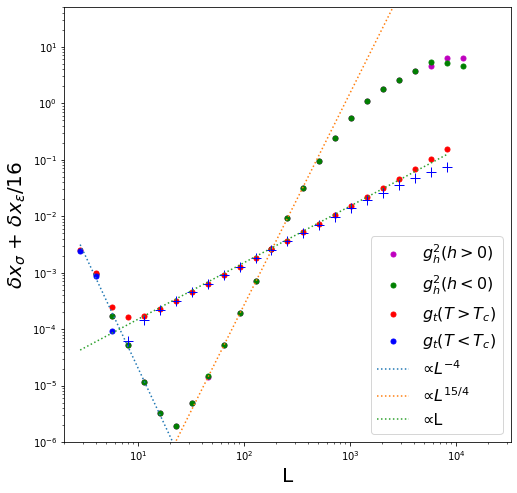

In [21]:
color_list= ["m", "g", "r", "b", "y", "k", "w"]
plt.figure(figsize=(8,8))
for i in range(4):
    if i >=2:
        plt.plot(l_list,((gap_list[i]-0.125)+(gap_list2[i]-1)/16),".",markersize=10,color=color_list[i],label=LABEL[i])
        plt.plot(l_list,-((gap_list[i]-0.125)+(gap_list2[i]-1)/16),"+",markersize=10,color=color_list[i])
    else:
        plt.plot(np.sqrt(2)*l_list,((gap_list[i]-0.125)+(gap_list2[i]-1)/16),".",markersize=10,color=color_list[i],label=LABEL[i])
        plt.plot(np.sqrt(2)*l_list,-((gap_list[i]-0.125)+(gap_list2[i]-1)/16),"+",markersize=10,color=color_list[i])
plt.plot(l_list,0.2*l_list**(-4),":",label="$∝L^{-4}$")
plt.plot(l_list[:80],8.5e-12*l_list[:80]**3.75,":",label="$∝L^{15/4}$")
plt.plot(l_list[:80],15e-6*l_list[:80],":",label="∝L")
plt.xscale("log")
plt.yscale("log")
plt.xlim(2,l_list[-1]*4)
plt.ylim(1e-6,50)
plt.legend(loc="lower right",fontsize=16)
plt.xlabel("L",fontsize=20)
plt.ylabel("$\delta x_\sigma$ + $\delta x_\epsilon/16$",fontsize=20)

After removing the irrelevant contributions from $T^2$ and $\bar{T}^2$, the next leading contributions $\sim 1/L^4$ appear.

In [22]:
nn=5
t_list=((gap_list[2,nn:]-0.125)+(gap_list2[2,nn:]-1)/16)
t_list2=((gap_list[3,nn:]-0.125)+(gap_list2[3,nn:]-1)/16)
h_list=np.sqrt(np.abs((gap_list[0,nn:]-0.125)+(gap_list2[0,nn:]-1)/16))
h_list2=-np.sqrt(np.abs((gap_list[1,nn:]-0.125)+(gap_list2[1,nn:]-1)/16))

<IPython.core.display.Javascript object>


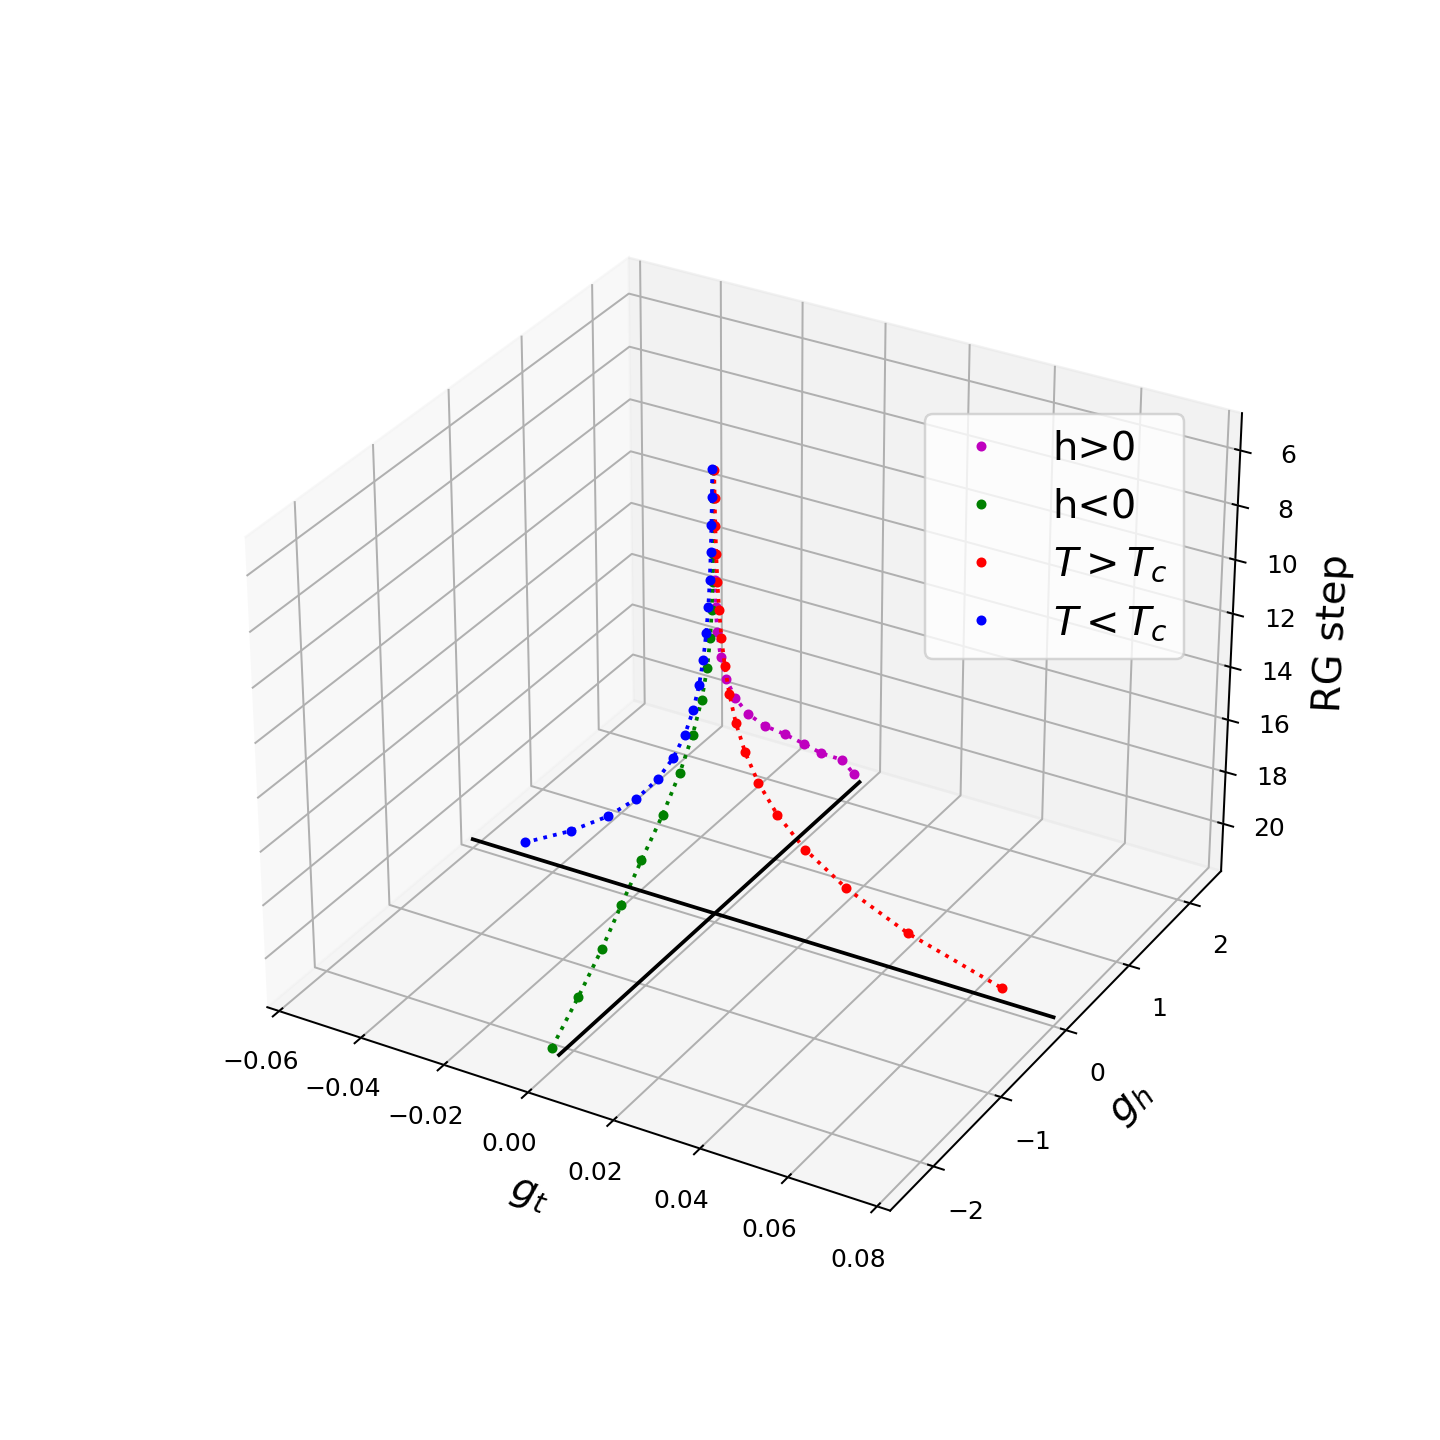

Text(0.5, 0, 'RG step')

In [23]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (8, 8))

# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')
ax.plot(np.zeros(17),h_list[:-2],np.arange(5,22),".",color=color_list[0],markersize=6,label="h>0")
ax.plot(np.zeros(17),h_list[:-2],np.arange(5,22),":",color=color_list[0])
ax.plot(np.zeros(17),h_list2[:-2],np.arange(5,22),".",color=color_list[1],markersize=6,label="h<0")
ax.plot(np.zeros(17),h_list2[:-2],np.arange(5,22),":",color=color_list[1])
ax.plot(t_list[:-2],np.zeros(17),np.arange(5,22),".",color=color_list[2],markersize=6,label="$T>T_c$")
ax.plot(t_list[:-2],np.zeros(17),np.arange(5,22),":",color=color_list[2])
ax.plot(t_list2[:-2],np.zeros(17),np.arange(5,22),".",color=color_list[3],markersize=6,label="$T<T_c$")
ax.plot(t_list2[:-2],np.zeros(17),np.arange(5,22),":",color=color_list[3])
ax.plot(np.linspace(-0.06,0.08,10),np.zeros(10),np.zeros(10)+21.5,color="black")
ax.plot(np.zeros(10),np.linspace(-2.2,2.2,10),np.zeros(10)+21.5,color="black")
plt.legend(bbox_to_anchor=(0.92, 0.8),loc="upper right",fontsize=16)
plt.xlim(-0.06,0.08)
ax.set_zlim(21.5,5)
plt.xlabel("$g_t$",fontsize=16)
plt.ylabel("$g_h$",fontsize=16)
ax.set_zlabel("RG step",fontsize=16)